## Forecasting of Daily Sales using SARIMAX
 This project is aimed at forecasting saily sales using past sales and leads data from different online channels. It uses a dummy data with Sales and Leads numbers for each day.

### Importing Required Libraries

In [3]:
import os                                   # os & directory operations package
import pandas as pd                         # data tools package
import numpy as np                          # number tools package
import matplotlib.pyplot as plt             # plots package
import seaborn as sns                       # good looking plots package
sns.set()
import statsmodels.graphics.tsaplots as sgt # timese
from sklearn.preprocessing import MinMaxScaler # For nornalizing
import statsmodels.tsa.stattools as sts     # 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from IPython.display import Image
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

### Defining LLR Test for Model Selection

In [179]:
# mod_1 is lower order model
# mod_2 is higher order model
# DF = number of coefficients of higher order model - number of coefficients of lower order model
# If this function returns value <= 0.05 , the higher order model is significantly better 

def LLR_Test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p    

### Defining ADF Test for Stationarity

In [180]:
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary for", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

### Function for returning Model Metrics

In [181]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    accuracy = 100 - (100*mape)
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'accuracy': accuracy, 'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

### Importing data

In [182]:
dataset = pd.read_csv(r'data.csv')
dataset.head(3)

,date,Leads,Sales,Direct_Leads_GA,Display_Leads_GA,Organic_Leads_GA,Paid Search_Leads_GA,Social_Leads_GA
0,2018-05-08,3542,106,354.0,112,118,162,259
1,2018-05-09,3284,86,354.0,112,118,162,259
2,2018-05-10,3073,93,354.0,112,118,162,259


### Data Preparation

In [183]:
# Copying for Preparation
dataset_preparation = dataset.copy()

# Checking for NA
dataset_preparation.isna().sum()

# If NA is present, handle it with one of below methods 

#dataset_for_prediction.fillna(method= 'backfill')
dataset_preparation=dataset_preparation.fillna(method= 'ffill')
#dataset_for_prediction.fillna(method= 'pad')
#dataset_for_prediction.fillna(method= 'bfill')


dataset_preparation.isna().sum()

date                    0
Leads                   0
Sales                   0
Direct_Leads_GA         0
Display_Leads_GA        0
Organic_Leads_GA        0
Paid Search_Leads_GA    0
Social_Leads_GA         0
dtype: int64

### Preparing Timeseries Data

In [184]:
# Making data into timeseries data
dataset_preparation["date"] = pd.to_datetime(dataset_preparation["date"], format="%Y-%m-%d")
dataset_preparation.head(3)

,date,Leads,Sales,Direct_Leads_GA,Display_Leads_GA,Organic_Leads_GA,Paid Search_Leads_GA,Social_Leads_GA
0,2018-05-08,3542,106,354.0,112,118,162,259
1,2018-05-09,3284,86,354.0,112,118,162,259
2,2018-05-10,3073,93,354.0,112,118,162,259


In [186]:
# Checking if the required date is converted to datetime format
print(type(dataset_preparation["date"][1]))
dataset_preparation["date"].describe()   

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


count                     979
unique                    979
top       2020-08-26 00:00:00
freq                        1
first     2018-05-08 00:00:00
last      2021-01-10 00:00:00
Name: date, dtype: object

In [187]:
# Setting the date as index (Mandatory for any timeseries analysis)
dataset_preparation.set_index("date", inplace=True)  # if the date column should be retained, use df.set_index(df["date"], inplace=True)
dataset_preparation.head(3)

,Leads,Sales,Direct_Leads_GA,Display_Leads_GA,Organic_Leads_GA,Paid Search_Leads_GA,Social_Leads_GA
date,,,,,,,
2018-05-08,3542,106,354.0,112,118,162,259
2018-05-09,3284,86,354.0,112,118,162,259
2018-05-10,3073,93,354.0,112,118,162,259


In [188]:
# Setting the frequency
dataset_preparation = dataset_preparation.asfreq('D', method='pad')

In [119]:
# Resampling data to Monthly Frequency
#dataset_preparation = dataset_preparation.resample('M').mean()
#dataset_preparation.head(3)

### Scaling the Data

In [189]:
# Scaling the target features
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_preparation[['Sales']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output
y.head(3)

,0
0,0.284519
1,0.200837
2,0.230126


In [190]:
# Renaming target variable

y.rename(columns={0:'Sales'}, inplace= True)
y.index=dataset_preparation.index
y.head(3)

,Sales
date,
2018-05-08,0.284519
2018-05-09,0.200837
2018-05-10,0.230126


In [122]:
dataset_preparation.columns

Index(['Leads', 'Sales', 'Direct_Leads_GA', 'Display_Leads_GA',
       'Organic_Leads_GA', 'Paid Search_Leads_GA', 'Social_Leads_GA'],
      dtype='object')

In [191]:
# Scaling the input features
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_preparation[['Direct_Leads_GA', 'Display_Leads_GA',
       'Organic_Leads_GA', 'Paid Search_Leads_GA', 'Social_Leads_GA']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input
X.head(3)

,0,1,2,3,4
0,0.066594,0.001516,0.006369,0.02051,0.04972
1,0.066594,0.001516,0.006369,0.02051,0.04972
2,0.066594,0.001516,0.006369,0.02051,0.04972


In [192]:
# Renaming the column names and indexing the input features
X.columns = ['Direct_Leads_GA', 'Display_Leads_GA',
       'Organic_Leads_GA', 'Paid Search_Leads_GA', 'Social_Leads_GA']
#X.rename(columns={0:'Direct_Leads_GA', 1:'Display_Leads_GA', 2:'Organic_Leads_GA', 3:'Paid_Search_Leads_GA', 4:'Social_Leads_GA'}, inplace=True)
X.index=dataset_preparation.index
X.head(3)

,Direct_Leads_GA,Display_Leads_GA,Organic_Leads_GA,Paid Search_Leads_GA,Social_Leads_GA
date,,,,,
2018-05-08,0.066594,0.001516,0.006369,0.02051,0.04972
2018-05-09,0.066594,0.001516,0.006369,0.02051,0.04972
2018-05-10,0.066594,0.001516,0.006369,0.02051,0.04972


### Handling NAs

In [193]:
# Checking for NA
y.isna().sum()

# If NA is present, handle it with one of below methods 

#dataset_for_prediction.fillna(method= 'backfill')
y=y.fillna(method= 'ffill')
X=X.fillna(method= 'ffill')
#dataset_for_prediction.fillna(method= 'pad')
#dataset_for_prediction.fillna(method= 'bfill')


y.isna().sum()

Sales    0
dtype: int64

### Train Test Split

In [195]:
# Our training set will be 70%, and the test set will be 30% of the entire data set.

train_share = 0.8

train_size=int(len(dataset_preparation) * train_share)   # setting 70% of dataset limit to train size
test_size = int(len(dataset_preparation)) - train_size

# Splitting the data  Note: there is no random sapling required here because it's time series, first 70% of the days are taken for training

train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()



### Seasonal Decomposition

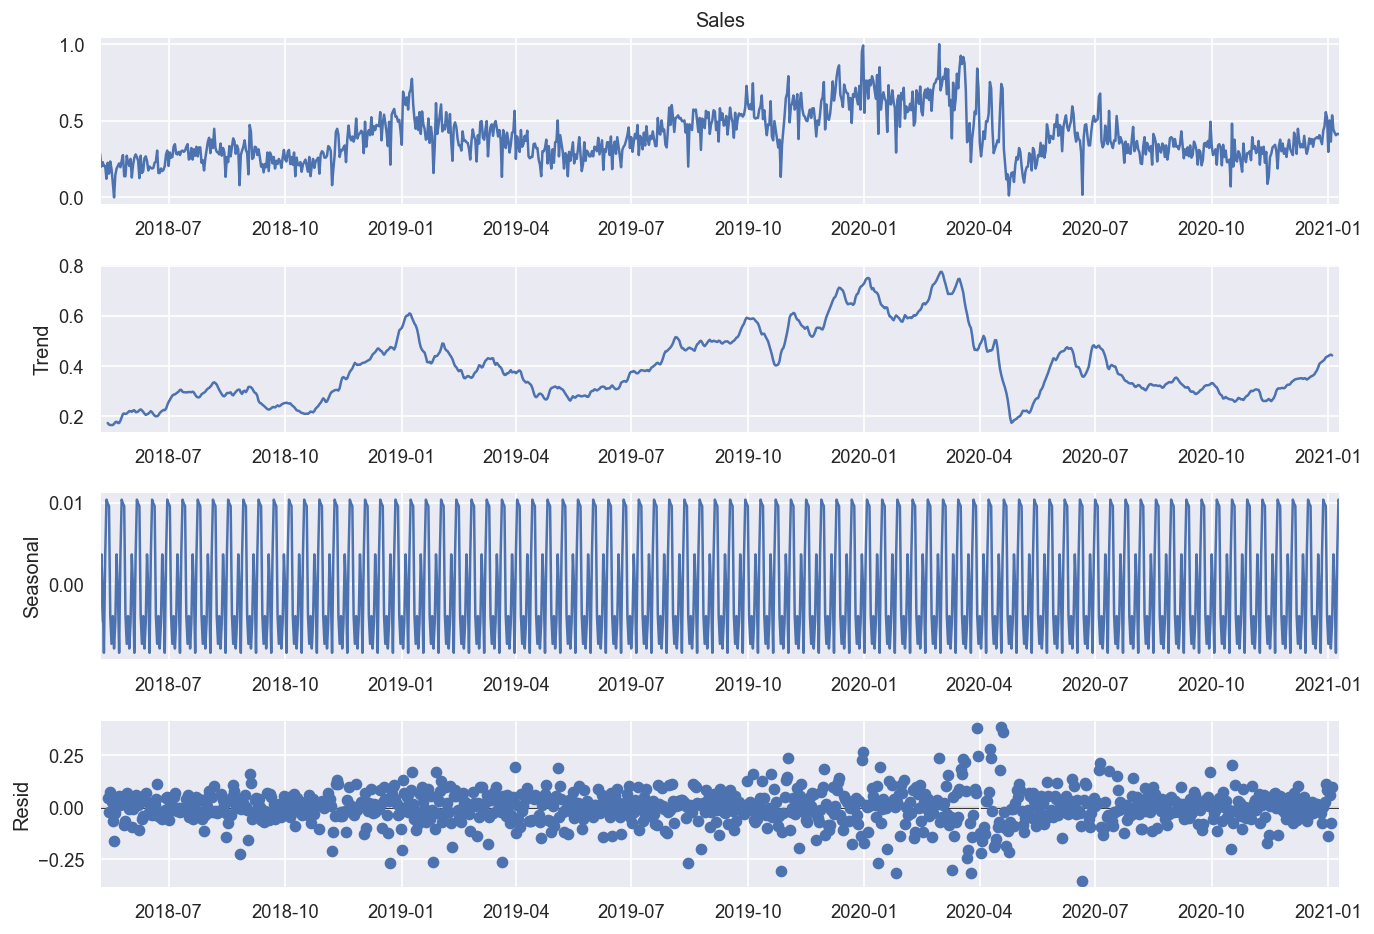

In [197]:
seas_d=sm.tsa.seasonal_decompose(y['Sales'].dropna(),model='add',period=12);
fig=seas_d.plot()
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show();

### Stationarity test

In [198]:
#Running the ADF test for Target Variable
test_adf(y['Sales'], "Sales")

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Sales


In [200]:
# Using one order difference
test_adf(y['Sales'].diff(1), "Sales")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary for Sales


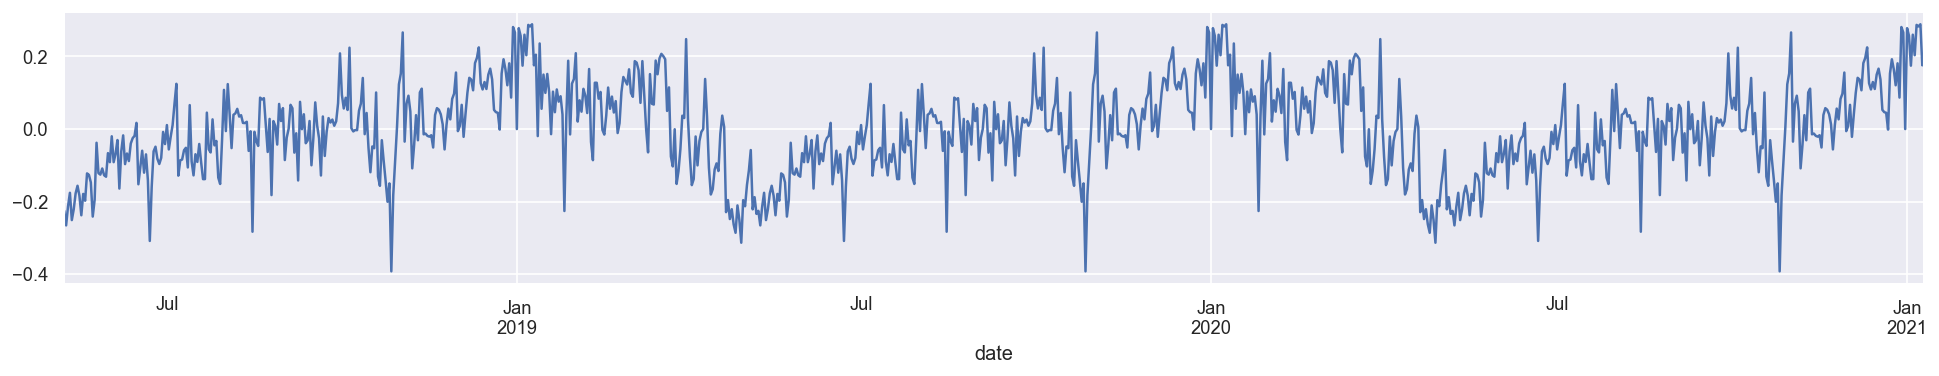

In [201]:
# Additive model
seas_d=sm.tsa.seasonal_decompose(y["Sales"],model='add',period=365);
fig=seas_d.seasonal
fig.plot(figsize = (20,3))
plt.show();

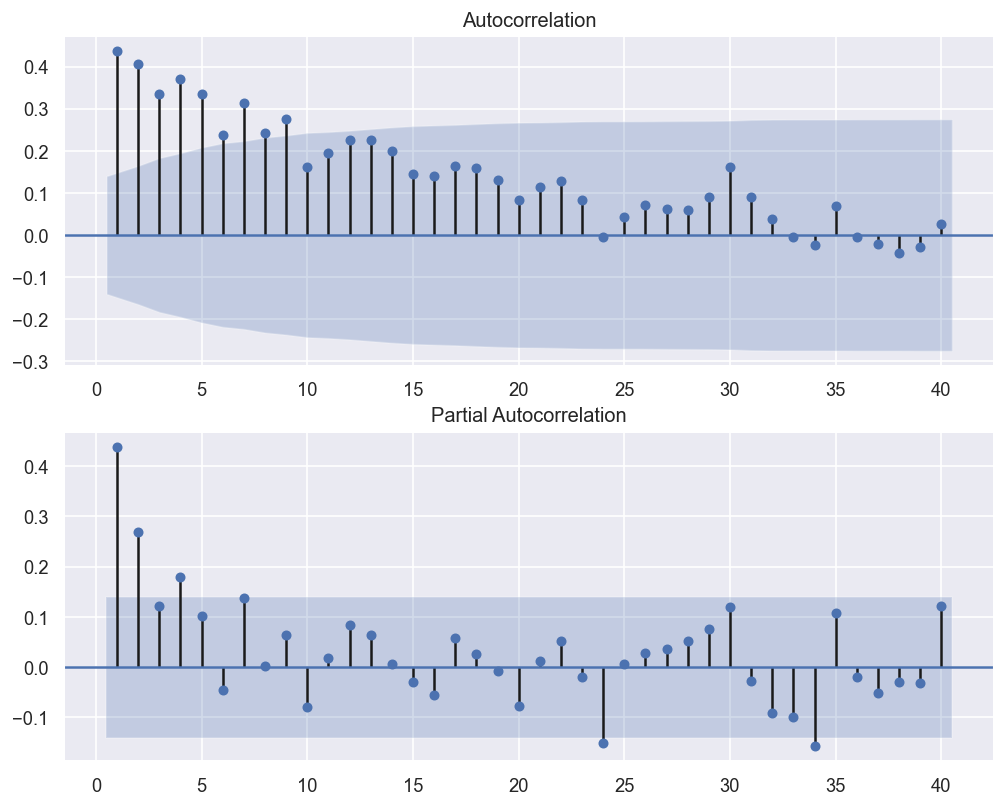

In [202]:
fig, ax= plt.subplots(2,1, figsize=(10,8))
fig=sm.tsa.graphics.plot_acf(test_y, lags=40, ax=ax[0], zero=False)   # common practice is to use 40 to 50 lags , zero=False this will ignore current period values in the graph
fig=sm.tsa.graphics.plot_pacf(test_y, lags=40, ax=ax[1], zero=False)
plt.show()

Last 4 periods of sales affect the latest sales and a week of error terms could help the model predict current sales.

In [26]:
# pyramid auto Arima function
#step_wise=auto_arima(
#    
# train_y,
#
#    
# start_p=1, 
# start_q=1, 
#    
# max_p=7, 
# max_q=7, 
#    
# d=1, 
# max_d=7,
#    
# trace=True, 
# error_action='ignore', 
# suppress_warnings=True, 
# stepwise=True)

In [ ]:
step_wise.summary()

In [ ]:
#Setting Example Models
#import itertools
#
#d = [1]
#p = range(0, 3)
#q = range(0, 8)
#P = Q = range(0, 3)
#pdq = list(itertools.product(p, d, q))
#PdQ = list(itertools.product(P, d, Q))
#seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(P, d, Q))]
#print('Examples of parameter for SARIMA...')
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

### Grid Search

In [133]:
import itertools
import warnings; 
warnings.simplefilter('ignore')

metric_aic_dict = dict()

#set parameter range
p = range(0,3)
q = range(1,8)
d = [1]

P = range(0,3)
Q = range(0,3)
s = [7]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, d, Q, s))

# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(
                                              train_y,
                                              order = param,
                                              seasonal_order= param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False
                                             )
            model_aic = model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,model_aic.aic))
            metric_aic_dict.update({(param,param_seasonal):model_aic.aic})
        except:
            continue

ARIMA(0, 1, 1)x(0, 1, 0, 7) - AIC:-1020.0035955320743
ARIMA(0, 1, 1)x(0, 1, 1, 7) - AIC:-1431.064414208803
ARIMA(0, 1, 1)x(0, 1, 2, 7) - AIC:-1411.4823716238545
ARIMA(0, 1, 1)x(1, 1, 0, 7) - AIC:-1211.7066327760306
ARIMA(0, 1, 1)x(1, 1, 1, 7) - AIC:-1422.0694635898499
ARIMA(0, 1, 1)x(1, 1, 2, 7) - AIC:-1412.1492145361033
ARIMA(0, 1, 1)x(2, 1, 0, 7) - AIC:-1258.5681554704954
ARIMA(0, 1, 1)x(2, 1, 1, 7) - AIC:-1415.0612936681332
ARIMA(0, 1, 1)x(2, 1, 2, 7) - AIC:-1410.2155299179544
ARIMA(0, 1, 2)x(0, 1, 0, 7) - AIC:-1073.8080390609878
ARIMA(0, 1, 2)x(0, 1, 1, 7) - AIC:-1439.2308338810535
ARIMA(0, 1, 2)x(0, 1, 2, 7) - AIC:-1418.5179248009704
ARIMA(0, 1, 2)x(1, 1, 0, 7) - AIC:-1219.533042355155
ARIMA(0, 1, 2)x(1, 1, 1, 7) - AIC:-1430.9537896629793
ARIMA(0, 1, 2)x(1, 1, 2, 7) - AIC:-1420.0203317060623
ARIMA(0, 1, 2)x(2, 1, 0, 7) - AIC:-1267.623720098456
ARIMA(0, 1, 2)x(2, 1, 1, 7) - AIC:-1424.4855272209652
ARIMA(0, 1, 2)x(2, 1, 2, 7) - AIC:-1417.1069726587034
ARIMA(0, 1, 3)x(0, 1, 0, 7) - A

ARIMA(2, 1, 5)x(1, 1, 0, 7) - AIC:-1288.6081708430645
ARIMA(2, 1, 5)x(1, 1, 1, 7) - AIC:-1435.7501852868106
ARIMA(2, 1, 5)x(1, 1, 2, 7) - AIC:-1417.9106081876203
ARIMA(2, 1, 5)x(2, 1, 0, 7) - AIC:-1294.2853269015236
ARIMA(2, 1, 5)x(2, 1, 1, 7) - AIC:-1423.8643391355508
ARIMA(2, 1, 5)x(2, 1, 2, 7) - AIC:-1414.9498416551887
ARIMA(2, 1, 6)x(0, 1, 0, 7) - AIC:-1268.5684375692063
ARIMA(2, 1, 6)x(0, 1, 1, 7) - AIC:-1434.7886463132172
ARIMA(2, 1, 6)x(0, 1, 2, 7) - AIC:-1412.8367583143697
ARIMA(2, 1, 6)x(1, 1, 0, 7) - AIC:-1286.362319011223
ARIMA(2, 1, 6)x(1, 1, 1, 7) - AIC:-1429.7859685594008
ARIMA(2, 1, 6)x(1, 1, 2, 7) - AIC:-1412.9018968495975
ARIMA(2, 1, 6)x(2, 1, 0, 7) - AIC:-1315.7746785936029
ARIMA(2, 1, 6)x(2, 1, 1, 7) - AIC:-1422.8611215243923
ARIMA(2, 1, 6)x(2, 1, 2, 7) - AIC:-1411.0971693513573
ARIMA(2, 1, 7)x(0, 1, 0, 7) - AIC:-1389.8895554100882
ARIMA(2, 1, 7)x(1, 1, 0, 7) - AIC:-1383.5877193383094
ARIMA(2, 1, 7)x(2, 1, 0, 7) - AIC:-1362.2787826486224


In [134]:
{k: v for k, v in sorted(metric_aic_dict.items(), key=lambda x: x[1])}

{((2, 1, 1), (0, 1, 1, 7)): -1447.609868634516,
 ((1, 1, 2), (0, 1, 1, 7)): -1446.767114035627,
 ((0, 1, 4), (0, 1, 1, 7)): -1446.547090130408,
 ((1, 1, 1), (0, 1, 1, 7)): -1445.8300933398314,
 ((1, 1, 4), (0, 1, 1, 7)): -1445.3417273043206,
 ((2, 1, 2), (0, 1, 1, 7)): -1444.9908439045464,
 ((1, 1, 2), (1, 1, 1, 7)): -1444.66460262648,
 ((2, 1, 4), (0, 1, 1, 7)): -1443.055309122215,
 ((2, 1, 2), (1, 1, 1, 7)): -1442.914971991556,
 ((0, 1, 5), (0, 1, 1, 7)): -1442.8243283117035,
 ((0, 1, 4), (1, 1, 1, 7)): -1441.3880148720364,
 ((0, 1, 3), (0, 1, 1, 7)): -1441.3782342706943,
 ((0, 1, 5), (1, 1, 1, 7)): -1440.7807895899425,
 ((1, 1, 5), (0, 1, 1, 7)): -1440.766204174296,
 ((1, 1, 4), (1, 1, 1, 7)): -1440.102507225187,
 ((0, 1, 2), (0, 1, 1, 7)): -1439.2308338810535,
 ((2, 1, 5), (0, 1, 1, 7)): -1438.6902844258489,
 ((0, 1, 6), (0, 1, 1, 7)): -1438.566524970266,
 ((1, 1, 5), (1, 1, 1, 7)): -1437.0379445302628,
 ((0, 1, 4), (2, 1, 1, 7)): -1436.6946623839658,
 ((2, 1, 4), (1, 1, 1, 7)): -1

### Selected Model Based on Grid Search

In [203]:


# With Exogenous
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_X= SARIMAX(train_y, 
 exog=train_X,
  order=(1,1,1),  
 seasonal_order=(0, 1, 1, 28),              
 enforce_invertibility=False,
 enforce_stationarity=False)



In [204]:
# Without Exogenous
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
 #exog=train_X,
  order=(1,1,1),  
 seasonal_order=(0, 1, 1, 28),               
 enforce_invertibility=False,
 enforce_stationarity=False)

In [205]:
# With Exogenous
results_X= model_X.fit()

In [206]:
# Without Exogenous
results= model.fit()

In [207]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  783
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 28)   Log Likelihood                 690.092
Date:                            Thu, 14 Jan 2021   AIC                          -1372.185
Time:                                    10:45:40   BIC                          -1353.845
Sample:                                05-08-2018   HQIC                         -1365.107
                                     - 06-28-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3673      0.035     10.364      0.000       0.298       0.437
ma.L1         -0.8537      0.024    -35.544      0.000      -0.901      -0.807
ma.S.L28      -1.0759      0.025    -42.918      0.000      -1.125      -1.027
sigma2         0.0071      0.000     17.601      0.000       0.006       0.008
===================================================================================
Ljung-Box (Q):                       63.45   Jarque-Bera (JB):                78.91
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.42   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [208]:
results_X.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  783
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 28)   Log Likelihood                 761.711
Date:                            Thu, 14 Jan 2021   AIC                          -1505.422
Time:                                    10:45:44   BIC                          -1464.159
Sample:                                05-08-2018   HQIC                         -1489.497
                                     - 06-28-2020                                         
Covariance Type:                              opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Direct_Leads_GA          0.0316      0.072      0.437      0.662      -0.110       0.173
Display_Leads_GA        -0.0890      0.057     -1.549      0.121      -0.202       0.024
Organic_Leads_GA         0.6555      0.098      6.714      0.000       0.464       0.847
Paid Search_Leads_GA     0.4279      0.147      2.918      0.004       0.140       0.715
Social_Leads_GA         -0.0196      0.053     -0.368      0.713      -0.124       0.085
ar.L1                    0.3287      0.041      7.920      0.000       0.247       0.410
ma.L1                   -0.8413      0.025    -34.121      0.000      -0.890      -0.793
ma.S.L28                -1.0630      0.035    -30.785      0.000      -1.131      -0.995
sigma2                   0.0060      0.000     14.761      0.000       0.005       0.007
===================================================================================
Ljung-Box (Q):                       50.01   Jarque-Bera (JB):                30.24
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

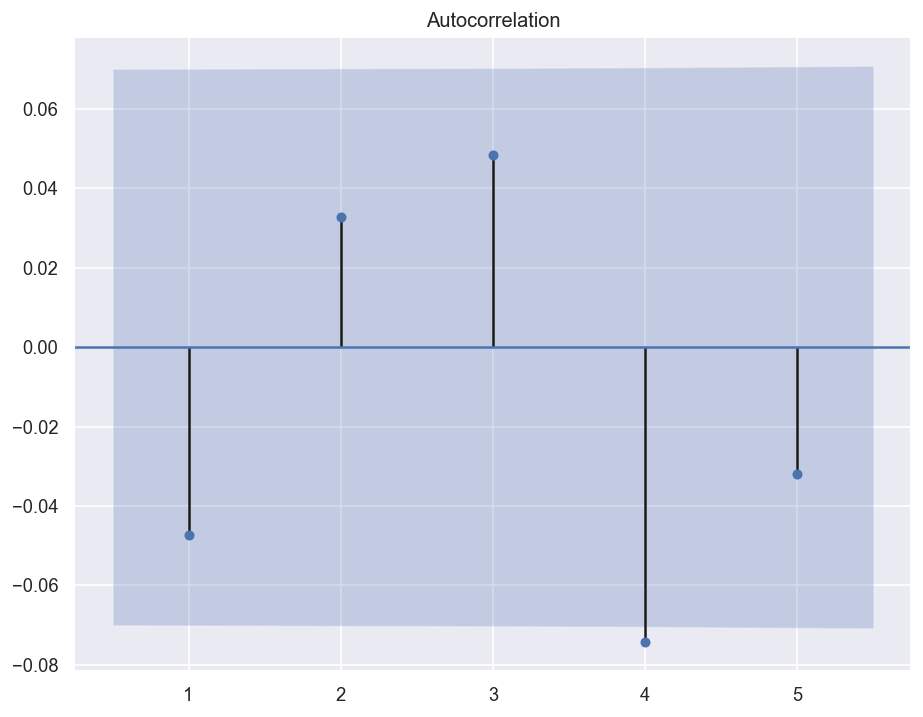

In [209]:
train_y_copy = train_y.copy()
train_y_copy["res"]  = results.resid
sgt.plot_acf(train_y_copy['res'].dropna(),zero=False,lags=5);

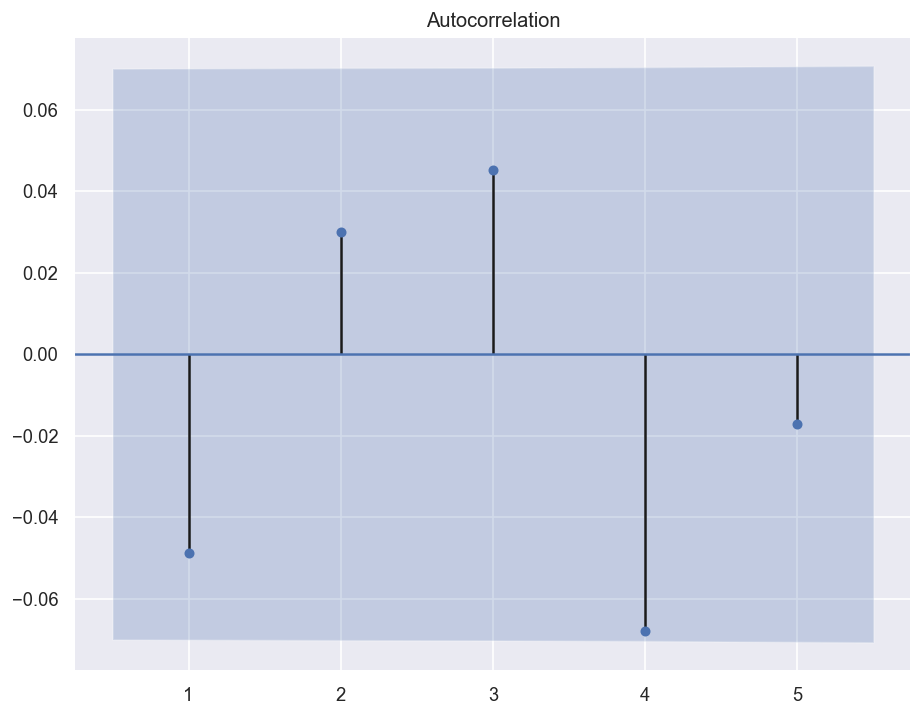

In [210]:
train_y_copy = train_y.copy()
train_y_copy["res"]  = results_X.resid
sgt.plot_acf(train_y_copy['res'].dropna(),zero=False,lags=5);

The above results indicate that the model has captured the correlated past terms.

In [238]:
print("Start Date ", test_y.head(1).index , " \n End Date ",  test_y.tail(1).index) 

Start Date  DatetimeIndex(['2020-06-29'], dtype='datetime64[ns]', name='date', freq='D')  
 End Date  DatetimeIndex(['2021-01-10'], dtype='datetime64[ns]', name='date', freq='D')


### Test and Predictions

In [211]:
test_start_date = '2020-02-19'
test_end_date = '2020-10-31'

In [212]:
# With Exogenous

# Making test set predictions

#Based on integer
#predictions= results.predict(start =train_size, end=train_size+test_size+(-1), exog=test_X)

#Based on dates
df_predictions_X= results_X.predict(start =train_size, end=train_size+test_size+(-1), exog=test_X)

In [213]:
# Without Exogenous

# Making test set predictions

#Based on integer
#predictions= results.predict(start =train_size, end=train_size+test_size+(-1), exog=test_X)

#Based on dates
df_predictions= results.predict(start =train_size, end=train_size+test_size+(-1))

In [214]:
#With Exogenous
forecast_X = results_X.get_forecast(steps=test_size, exog = test_X)

In [215]:
#Without Exogenous
forecast = results.get_forecast(steps=test_size)

In [ ]:
# Extracting Predicted values
Series_forecast_X = forecast_X.predicted_mean 
Series_forecast = forecast.predicted_mean 

# Making Dataframe out of predicted values (these contain the nornal values)
df_forecast_X = pd.DataFrame(Series_forecast_X, columns=[["Sales"]])
df_forecast = pd.DataFrame(Series_forecast, columns=[["Sales"]])

# Scaling Back
df_forecast_X_Original = sc_out.inverse_transform(df_forecast_X[['Sales']])
df_forecast_Original = sc_out.inverse_transform(df_forecast[['Sales']])
test_y_Original = sc_out.inverse_transform(test_y[['Sales']])


# Making Dataframe out of predicted values (these contain the original values)
df_forecast_X_Original = pd.DataFrame(df_forecast_X_Original, columns=["Sales"], index = test_y.index)
df_forecast_Original = pd.DataFrame(df_forecast_Original, columns=["Sales"], index = test_y.index)
test_y_Original = pd.DataFrame(test_y_Original, columns=["Sales"], index = test_y.index)

# Plot the Saceled back values
df_forecast_Original['Sales'].plot(figsize = (20,8), color = "cyan", label="Predictions", alpha=0.7)
df_forecast_X_Original['Sales'].plot(figsize = (20,8), color = "green", label="Predictions_X")
dataset_preparation['Sales']['2020':].plot(color = "black", alpha=0.5)
plt.title("Predictions",size = 24)
plt.legend()
plt.show()

### Without Exogenous

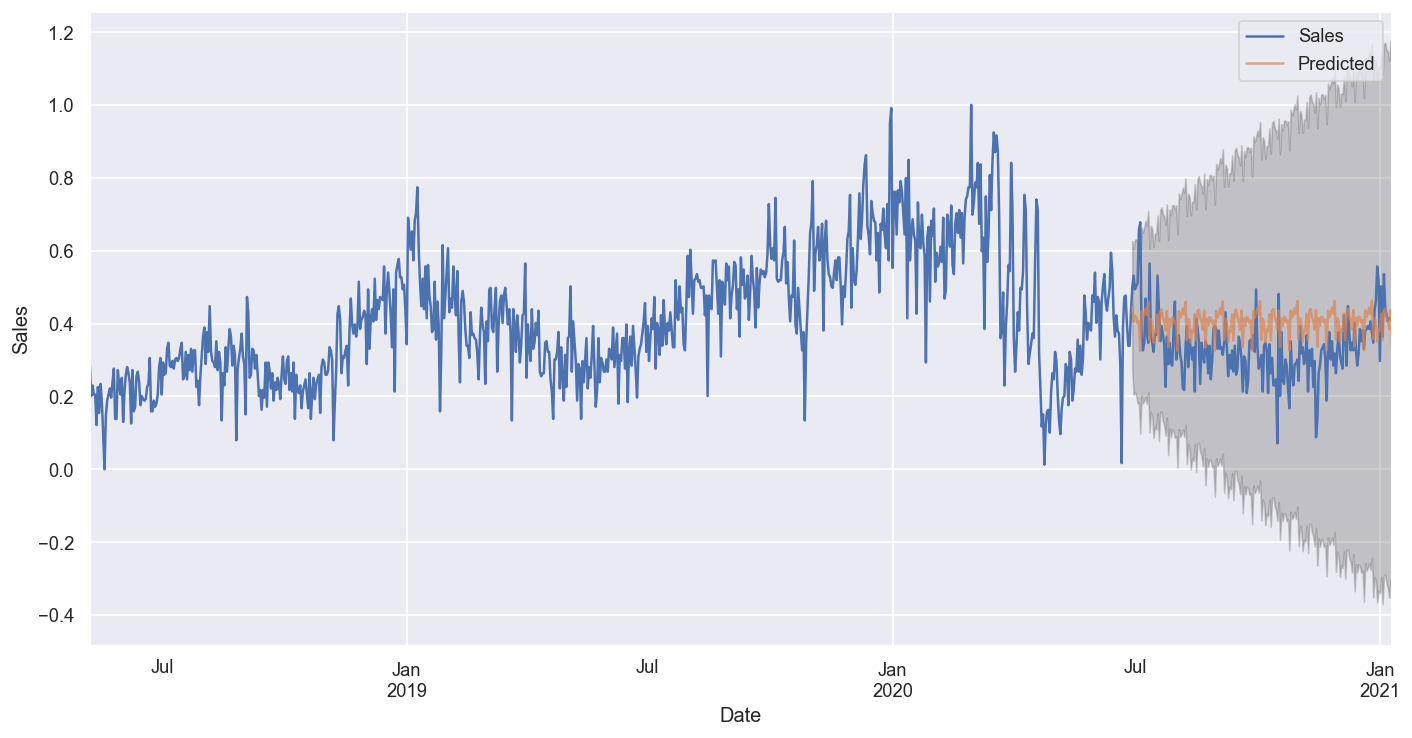

In [242]:
pred = results.get_prediction(start=pd.to_datetime('2020-06-29'),end=pd.to_datetime('2021-01-10'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2018':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

### With Exogenous

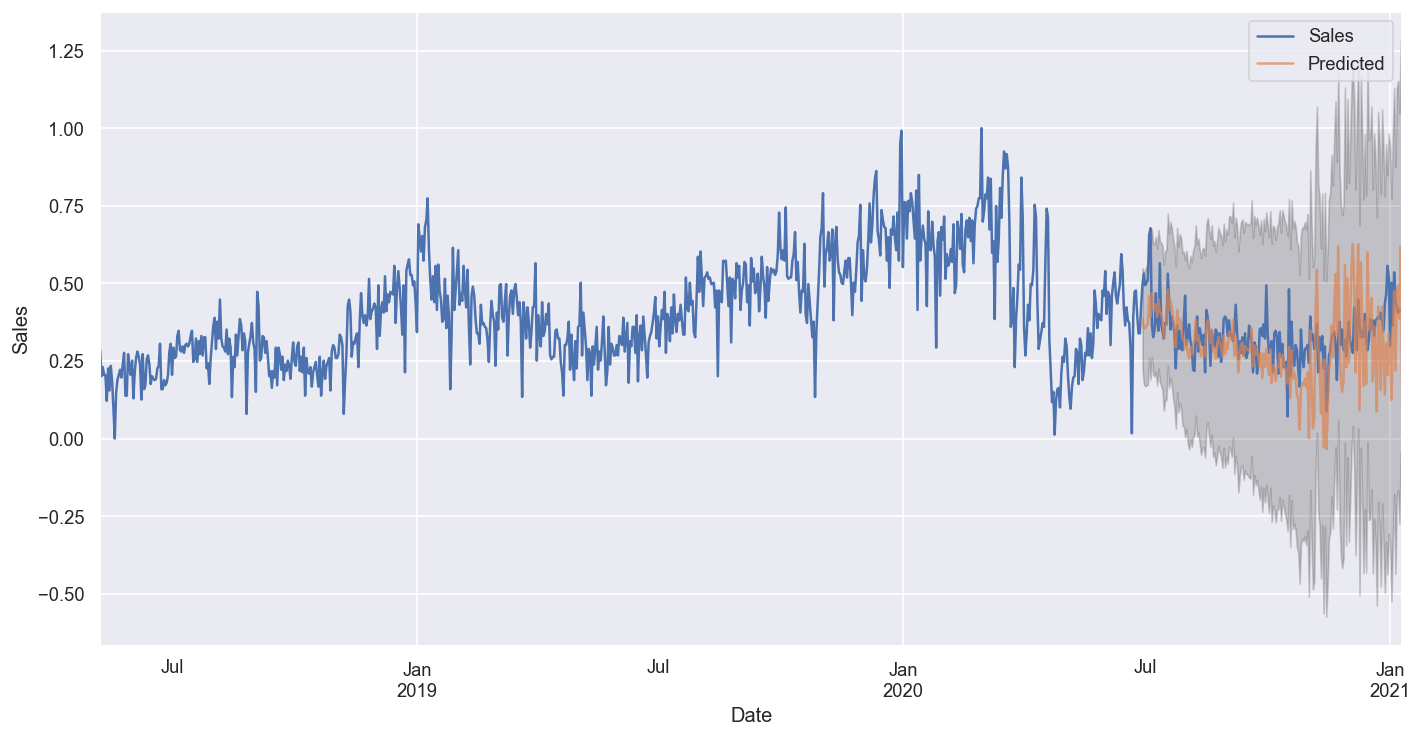

In [241]:
pred = results_X.get_prediction(start=pd.to_datetime('2020-06-29'),end=pd.to_datetime('2021-01-10'),  exog = test_X,  dynamic=False)
pred_ci = pred.conf_int()

ax = y['2018':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

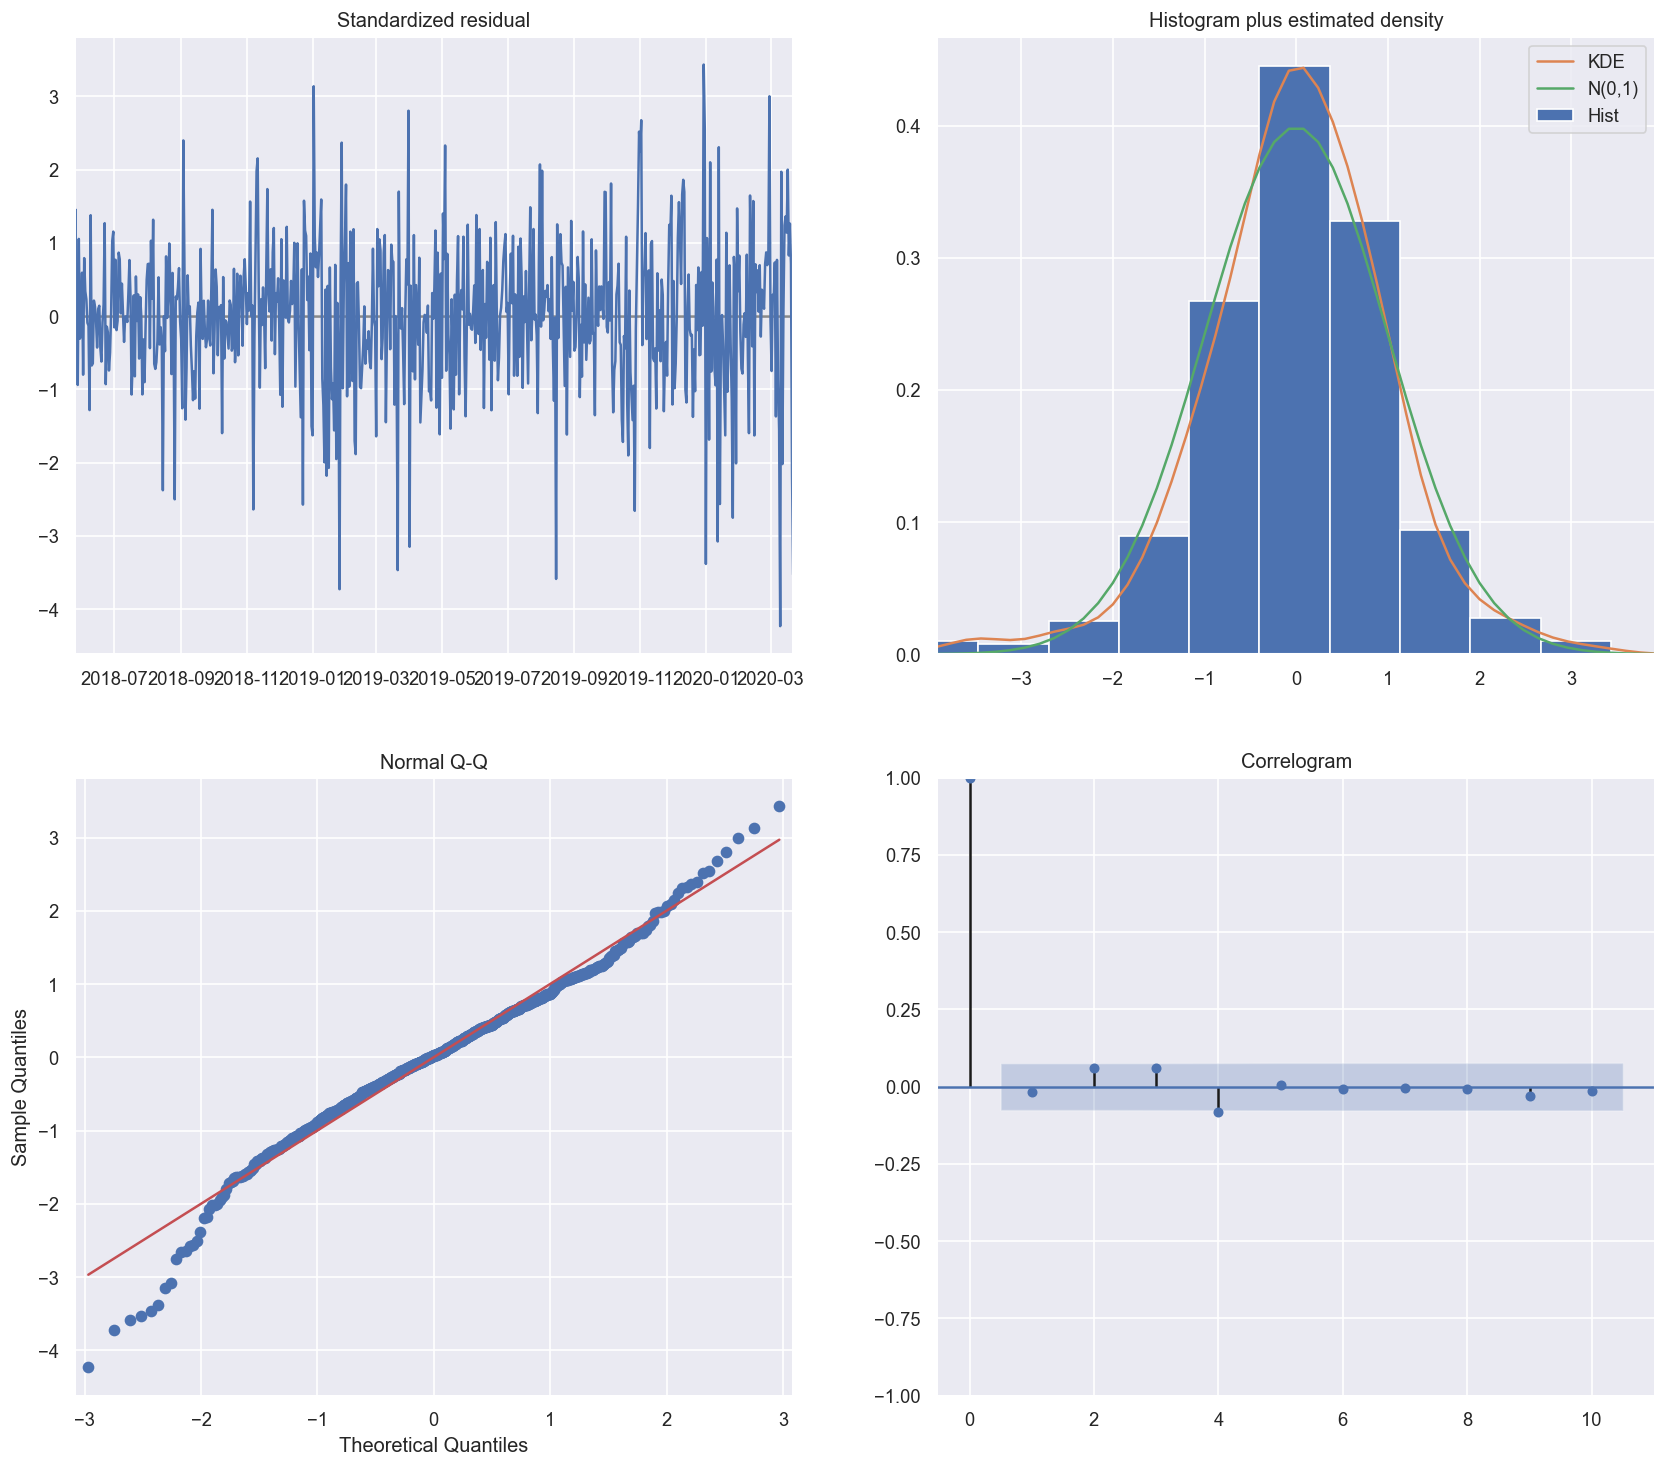

In [173]:
results.plot_diagnostics(figsize = (17,15));

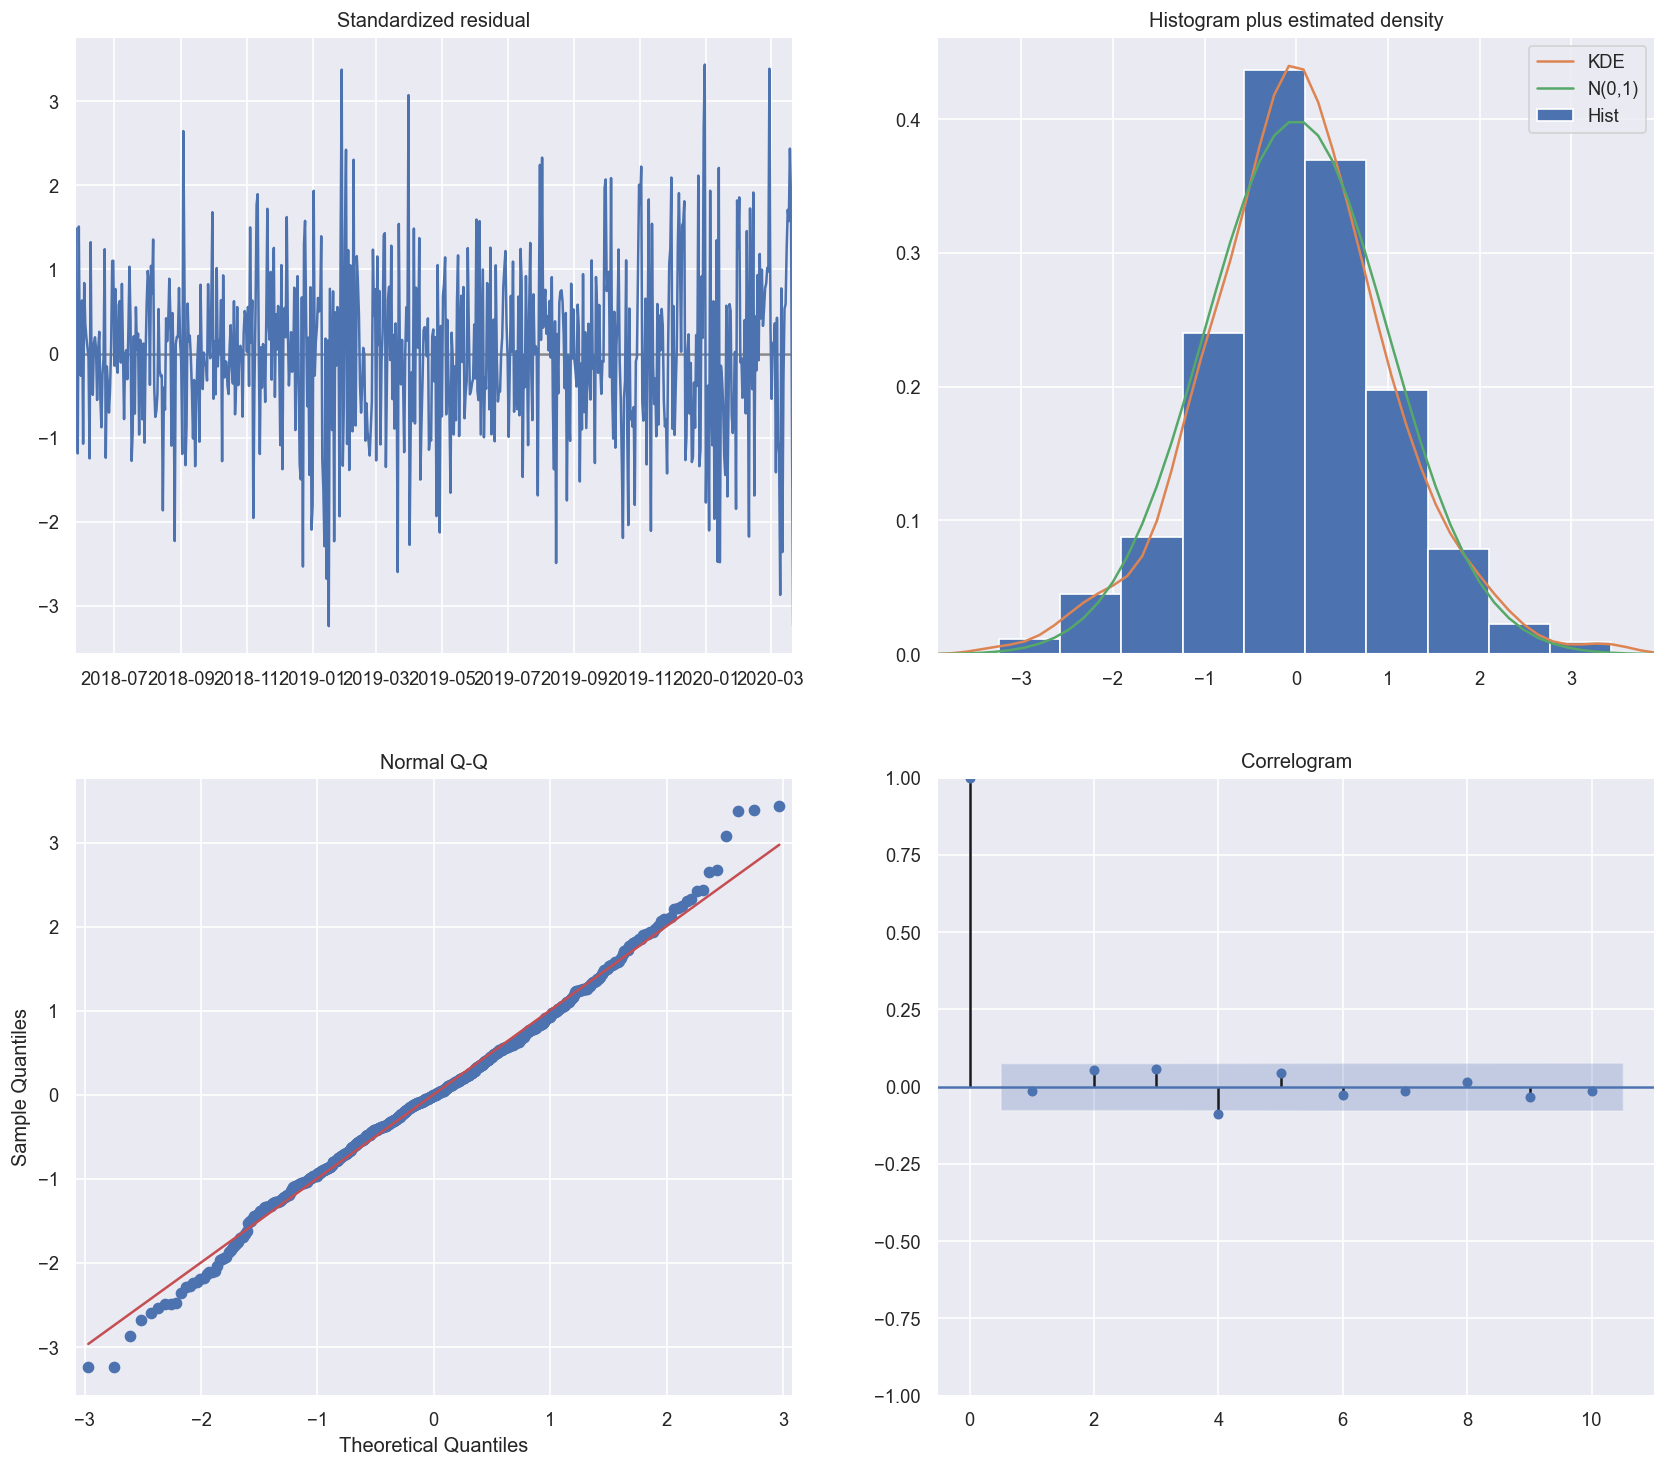

In [174]:
results_X.plot_diagnostics(figsize = (17,15));

In [217]:
# Finding Accuracy - without Exogenous
forecast_accuracy(df_forecast_Original.values, test_y_Original.values)

{'accuracy': 79.18713940190021,
 'mape': 0.20812860598099792,
 'me': 15.784471576052997,
 'mae': 22.32478172904074,
 'mpe': 0.1678462205037591,
 'rmse': 26.888986721534984,
 'acf1': 0.43146387716962964,
 'corr': nan,
 'minmax': 0.16036668155786593}

In [218]:
# Finding Accuracy  - with Exogenous
forecast_accuracy(df_forecast_X_Original.values, test_y_Original.values)

{'accuracy': 80.79753516899979,
 'mape': 0.19202464831000218,
 'me': -8.717053608147065,
 'mae': 22.850206026094803,
 'mpe': -0.06260809778145657,
 'rmse': 29.956751766159424,
 'acf1': 0.1970755916861454,
 'corr': nan,
 'minmax': 0.1765629491582773}

Selected is SARIMAX(1, 1, 1)x(0, 1, 1, 28)